# The [seeded] watershed algorithm
The watershed algorithm is traditionally used for cell segmentation in microscopy images when a membrane marker was used. If image quality and resolution is high, the algorithm works great. In cases where high image quality cannot be achieved, deep-learning approaches are outperforming the watershed algorithm.

We will use the scriptable napari plugin [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes). Under the hood, this plugin uses functions from [scikit-image](http://scikit-image.org/). We also use [napari-simpleitk-image-processing](https://github.com/haesleinhuepf/napari-simpleitk-image-processing) which is based on the [Insight Toolkit](https://itk.org/), maybe the oldest open-source image processing library on earth.

In [1]:
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_simpleitk_image_processing as nsitk
from skimage.io import imread, imshow
from skimage.data import cells3d
import stackview

As example we will use a single 2d slice from the [cells3d dataset from scikit-image](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d). The image has two channels: A nuclei-channel and a channel showing cell membranes.

C:\Users\rober\AppData\Local\Temp\ipykernel_22116\1465126183.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(nuclei_image)


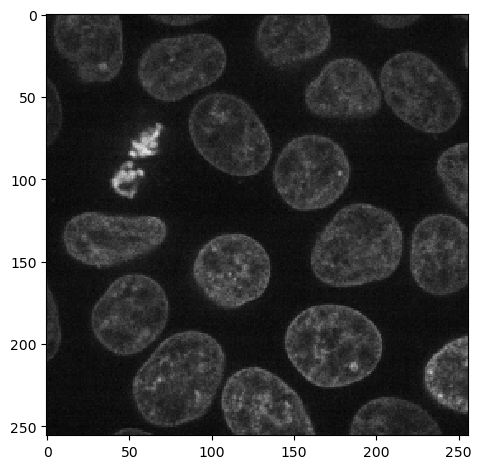

In [2]:
image_stack = cells3d()

nuclei_image = image_stack[30, 1]
imshow(nuclei_image)

C:\Users\rober\AppData\Local\Temp\ipykernel_22116\2629643589.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(membrane_image, vmax=10000)


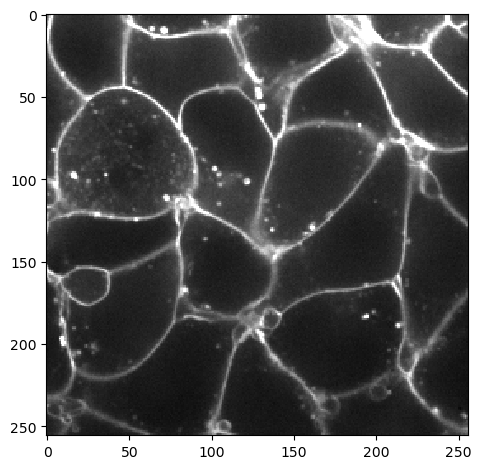

In [3]:
membrane_image = image_stack[30, 0]
imshow(membrane_image, vmax=10000)

Before we can apply the seeded watershed algorithm, we need seeds. The nuclei channel allows us to make seeds, e.g. using the Voronoi-Otsu-Labeling algorithm.

StackViewNDArray([[0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
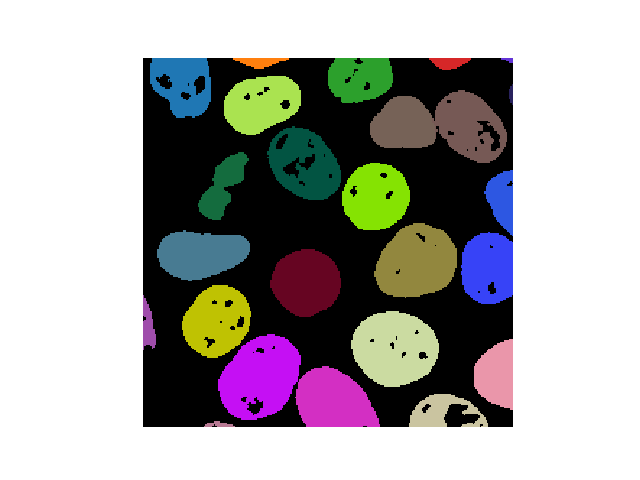

In [4]:
nuclei_labels = nsbatwm.voronoi_otsu_labeling(nuclei_image, spot_sigma=10, outline_sigma=1)

nuclei_labels

We can then use these seeds to flood the membrane-image using the watershed algorithm.

StackViewNDArray([[ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  ...,
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25]])
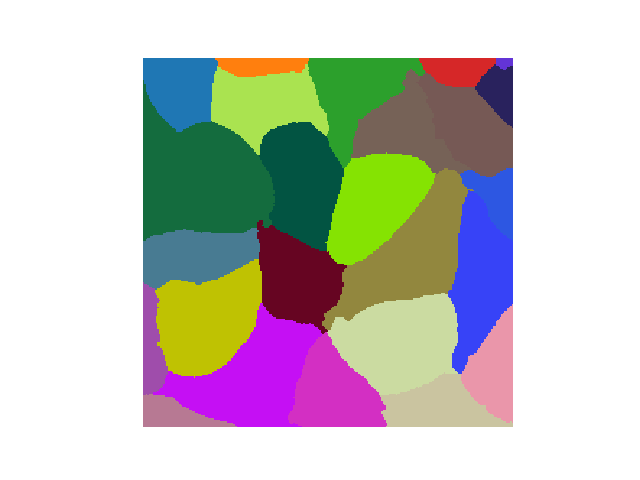

In [5]:
cell_labels = nsbatwm.seeded_watershed(membrane_image, nuclei_labels)

cell_labels

In case the segmentation would not look perfect, it is common to apply pre-processing filters to the membrane image. This allows to make outlines smoother for example:

StackViewNDArray([[0.08361556, 0.0828579 , 0.08079231, ..., 0.05523675,
                   0.05358634, 0.0524809 ],
                  [0.08603551, 0.08476939, 0.08215579, ..., 0.05900686,
                   0.05729538, 0.05611175],
                  [0.08927427, 0.08733416, 0.08400518, ..., 0.06332498,
                   0.06150674, 0.06018969],
                  ...,
                  [0.02331809, 0.02419461, 0.02532956, ..., 0.05234594,
                   0.05401739, 0.05551734],
                  [0.02334306, 0.0242519 , 0.02541235, ..., 0.05245207,
                   0.05419578, 0.05575007],
                  [0.02342579, 0.02437453, 0.02556989, ..., 0.05215082,
                   0.0539475 , 0.05554074]])
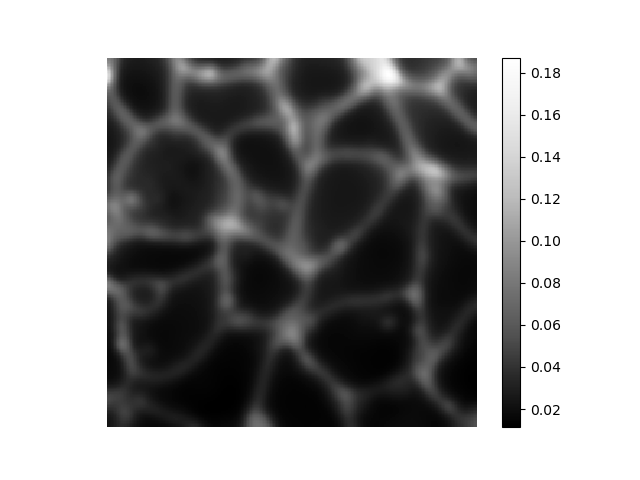
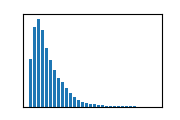

In [6]:
blurred_image = nsbatwm.gaussian_blur(membrane_image, sigma=4)

blurred_image

StackViewNDArray([[ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  ...,
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25]])
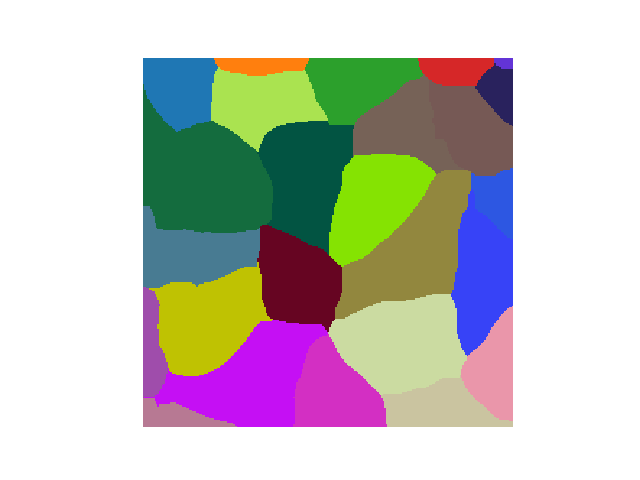

In [7]:
cell_labels2 = nsbatwm.seeded_watershed(blurred_image, nuclei_labels)

cell_labels2

## Splitting touching objects
There are other use-cases for the watershed algorithm. In this section we will split objects in binary images that have a roundish shape and touch each other. 

Starting point for this is a binary image, e.g. made using [thresholding](image-segmentation:thresholding).

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
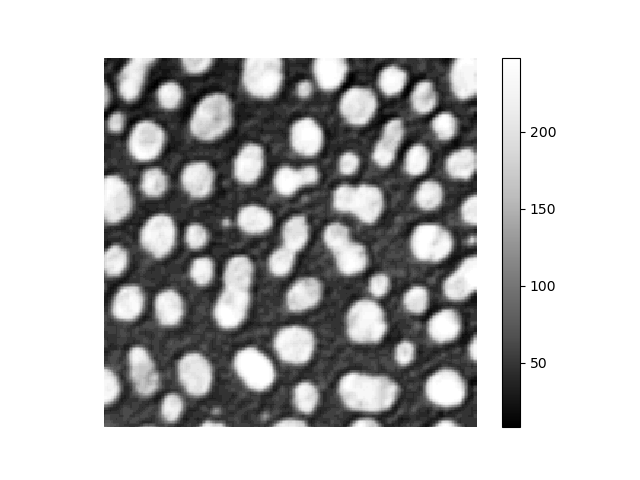
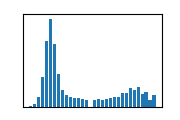

In [9]:
blobs = imread('../02a_image_processing/data/blobs.tif')

stackview.insight(blobs)

StackViewNDArray([[False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
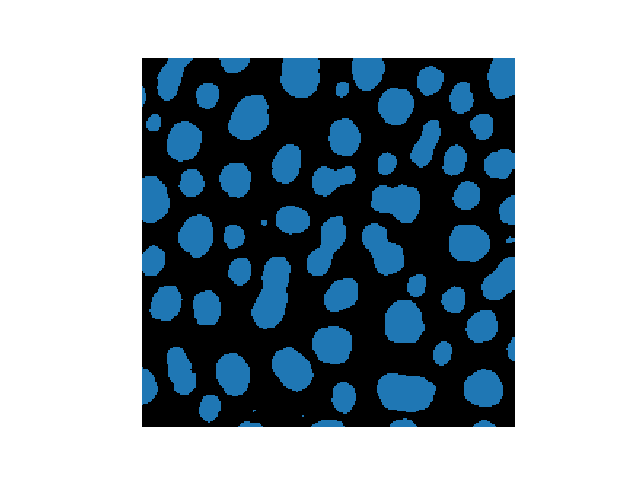

In [10]:
binary = nsbatwm.threshold_otsu(blobs).astype(bool)

binary

We can then split the touching object by only taking the binary image into account. The underlying algorithm aims to produce similar results to [ImageJ's binary watershed algorithm](https://imagej.nih.gov/ij/docs/menus/process.html#watershed) and the implementation here also works in 3D.

c:\structure\code\stackview\stackview\_static_view.py:101: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


StackViewNDArray([[False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
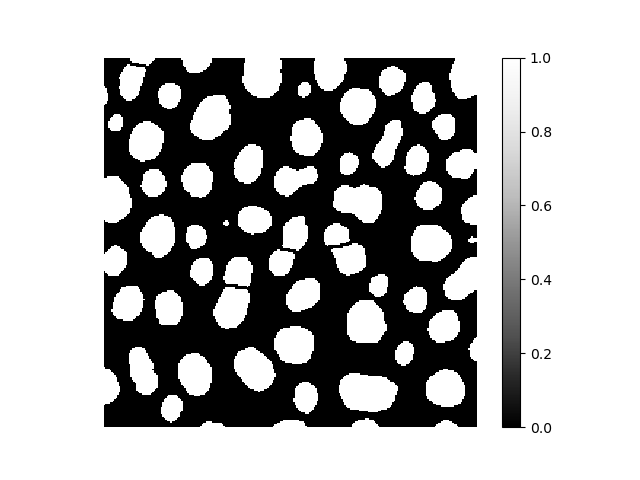
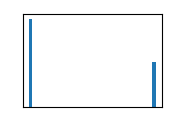

In [11]:
split_objects = nsbatwm.split_touching_objects(binary)
split_objects

It is also possible to retrieve a label image as result. Note that in this case, the black line/gap between objects will not be present.

StackViewNDArray([[0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
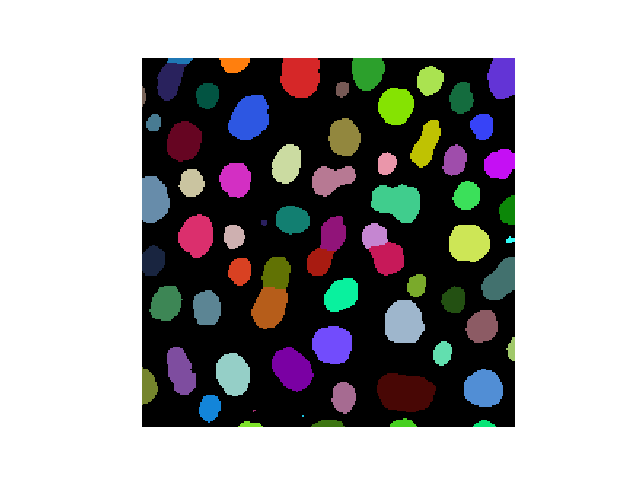

In [12]:
touching_labels = nsitk.touching_objects_labeling(binary)
touching_labels

## Exercise
Turn the binary image above in a label image.
Use label morphology operations and basic math operations to turn the label image above in a binary image that looks similar.

Compare both binary images and the label images. What's different?